In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from roboflow import Roboflow
import numpy as np
import cv2



loading Roboflow workspace...
loading Roboflow project...
Dataset location: d:\Bangkit\Capstone_Egglyze\Deteksi-Telur-+-Satuan-6
Files in dataset directory:
d:\Bangkit\Capstone_Egglyze\Deteksi-Telur-+-Satuan-6\README.dataset.txt
d:\Bangkit\Capstone_Egglyze\Deteksi-Telur-+-Satuan-6\README.roboflow.txt
d:\Bangkit\Capstone_Egglyze\Deteksi-Telur-+-Satuan-6\test\Eggs-9Y3v-EIEh.tfrecord
d:\Bangkit\Capstone_Egglyze\Deteksi-Telur-+-Satuan-6\test\Eggs-9Y3v-EIEh_label_map.pbtxt
d:\Bangkit\Capstone_Egglyze\Deteksi-Telur-+-Satuan-6\train\Eggs-9Y3v-EIEh.tfrecord
d:\Bangkit\Capstone_Egglyze\Deteksi-Telur-+-Satuan-6\train\Eggs-9Y3v-EIEh_label_map.pbtxt
d:\Bangkit\Capstone_Egglyze\Deteksi-Telur-+-Satuan-6\valid\Eggs-9Y3v-EIEh.tfrecord
d:\Bangkit\Capstone_Egglyze\Deteksi-Telur-+-Satuan-6\valid\Eggs-9Y3v-EIEh_label_map.pbtxt
TFRecord files found: ['d:\\Bangkit\\Capstone_Egglyze\\Deteksi-Telur-+-Satuan-6\\test\\Eggs-9Y3v-EIEh.tfrecord', 'd:\\Bangkit\\Capstone_Egglyze\\Deteksi-Telur-+-Satuan-6\\train\\Egg

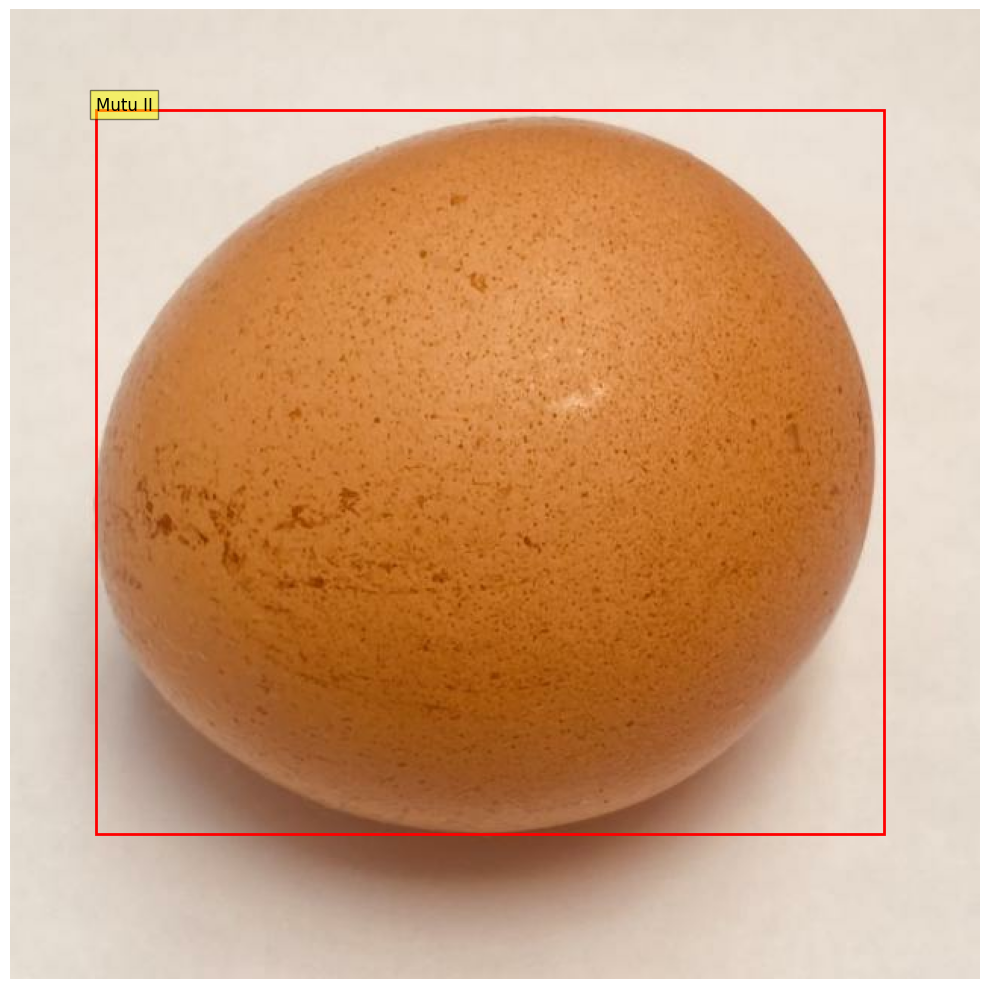

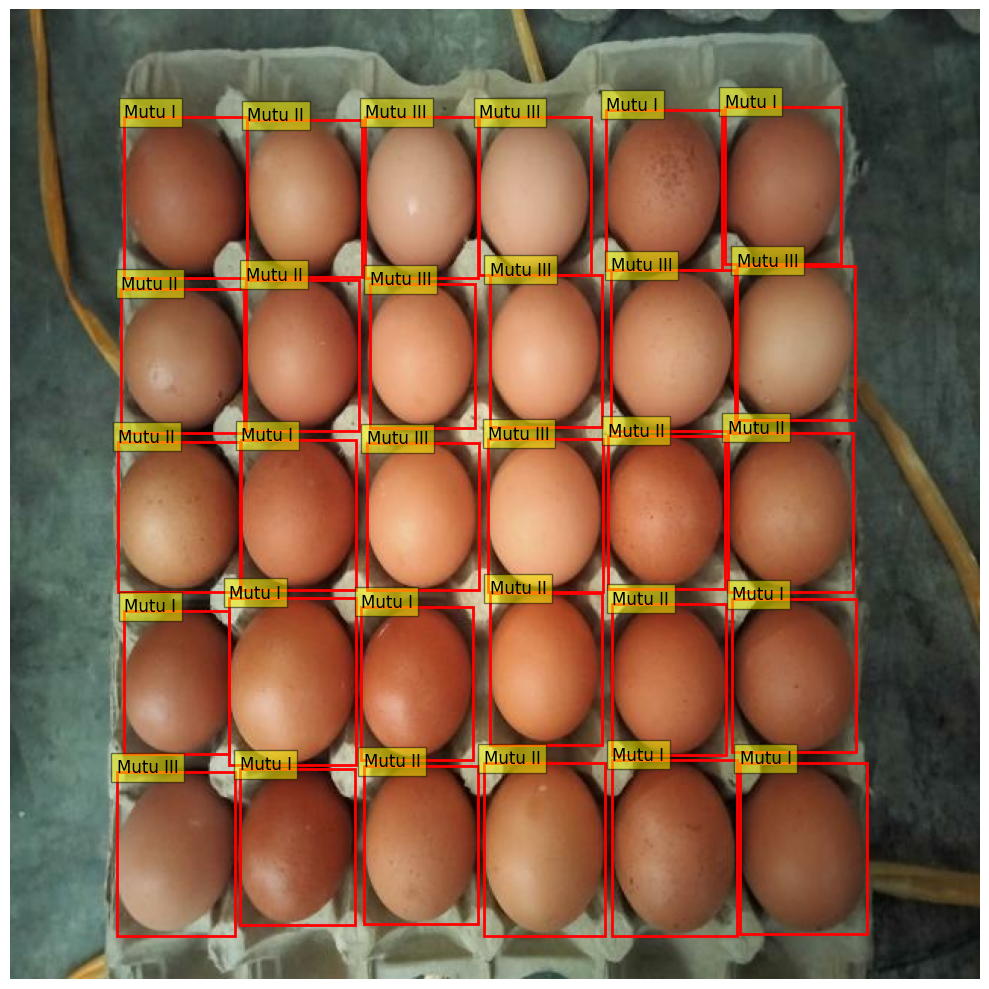

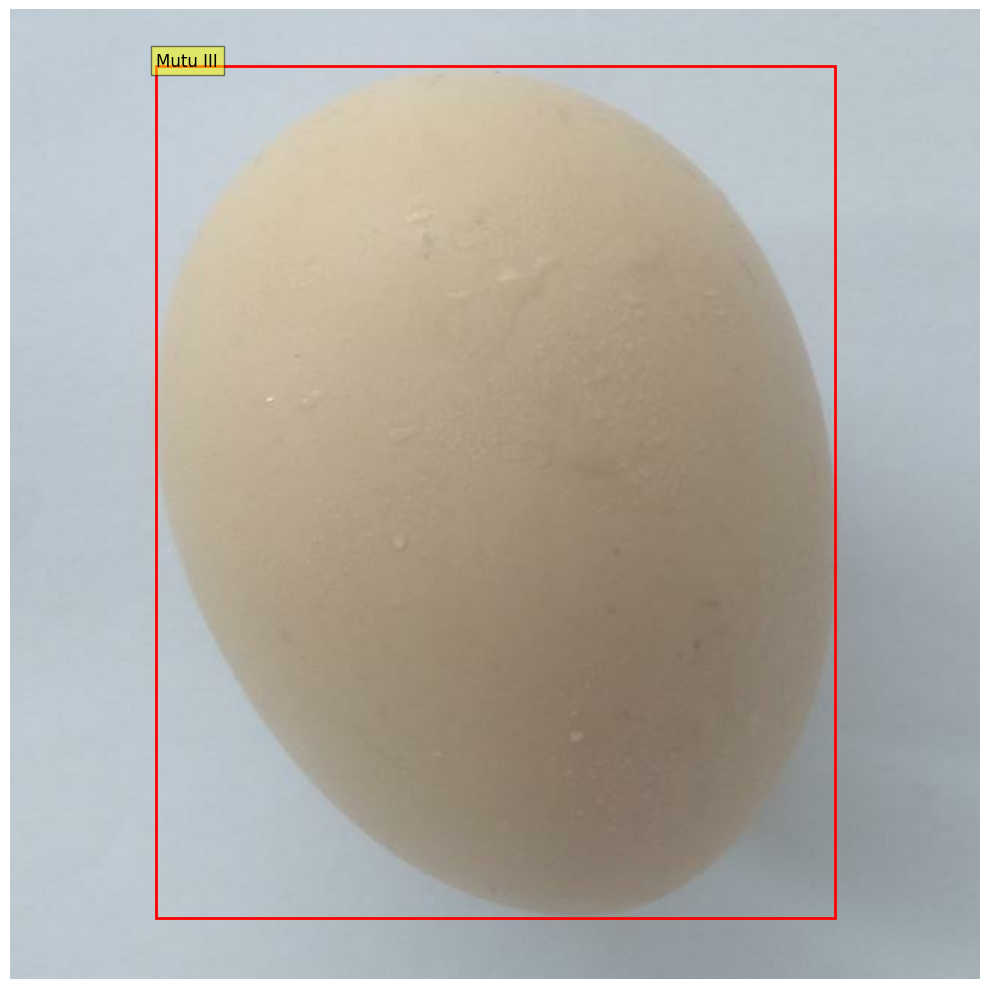

In [9]:

rf = Roboflow(api_key="vGBVDZgHgKG2ukU1kEpK")
project = rf.workspace("deteksi-telur-lk5ut").project("deteksi-telur-satuan")
version = project.version(6)
dataset = version.download("tfrecord")

print("Dataset location:", dataset.location)

print("Files in dataset directory:")
for root, dirs, files in os.walk(dataset.location):
    for file in files:
        print(os.path.join(root, file))

def parse_tfrecord(example_proto):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64)
    }
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    
    
    image = tf.image.decode_image(parsed_features['image/encoded'], channels=3)
    
   
    xmin = tf.sparse.to_dense(parsed_features['image/object/bbox/xmin'])
    xmax = tf.sparse.to_dense(parsed_features['image/object/bbox/xmax'])
    ymin = tf.sparse.to_dense(parsed_features['image/object/bbox/ymin'])
    ymax = tf.sparse.to_dense(parsed_features['image/object/bbox/ymax'])
    labels = tf.sparse.to_dense(parsed_features['image/object/class/label'])
    
    return image, xmin, xmax, ymin, ymax, labels

def show_image_with_bboxes(image, xmin, xmax, ymin, ymax, labels):
    plt.figure(figsize=(10, 10))
    plt.imshow(image.numpy())
    
    height, width, _ = image.shape
    
    
    class_names = ['Mutu I', 'Mutu II', 'Mutu III']
    
    for i in range(len(labels)):
        
        x_min = xmin[i] * width
        x_max = xmax[i] * width
        y_min = ymin[i] * height
        y_max = ymax[i] * height
        
    
        rect = patches.Rectangle(
            (x_min, y_min), 
            x_max - x_min, 
            y_max - y_min, 
            linewidth=2, 
            edgecolor='r', 
            facecolor='none'
        )
        plt.gca().add_patch(rect)
        
        
        label_text = class_names[labels[i] - 1] if 1 <= labels[i] <= len(class_names) else 'Unknown'
        plt.text(x_min, y_min, label_text, 
                 bbox=dict(facecolor='yellow', alpha=0.5), 
                 fontsize=12, 
                 color='black')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()


tfrecord_files = []
for root, dirs, files in os.walk(dataset.location):
    tfrecord_files.extend([os.path.join(root, f) for f in files if f.endswith('.tfrecord')])

print("TFRecord files found:", tfrecord_files)


if tfrecord_files:
    
    train_tfrecord_path = tfrecord_files[0]
    train_dataset = tf.data.TFRecordDataset(train_tfrecord_path)
    train_dataset = train_dataset.map(parse_tfrecord)

    print("Menampilkan gambar dengan anotasi:")
    for image, xmin, xmax, ymin, ymax, labels in train_dataset.take(3):
        show_image_with_bboxes(image, xmin, xmax, ymin, ymax, labels)
else:
    print("Tidak ada file TFRecord yang ditemukan!")

In [ ]:


def create_dirs(base_path, splits, classes):
    for split in splits:
        for cls in classes:
            dir_path = os.path.join(base_path, split, cls)
            os.makedirs(dir_path, exist_ok=True)

output_dir = "dataset_split"
splits = ["train", "valid", "test"]
class_names = ['Mutu I', 'Mutu II', 'Mutu III']


create_dirs(output_dir, splits, class_names)

def save_image_with_bboxes(image, xmin, xmax, ymin, ymax, labels, split):
    height, width, _ = image.shape
    image_np = image.numpy()
    
    for i in range(len(labels)):
        label = labels[i]
        cls_name = class_names[label - 1] if 1 <= label <= len(class_names) else "Unknown"
        

        x_min = int(xmin[i] * width)
        x_max = int(xmax[i] * width)
        y_min = int(ymin[i] * height)
        y_max = int(ymax[i] * height)
        
        
        image_with_box = image_np.copy()
        image_with_box = cv2.rectangle(
            image_with_box, 
            (x_min, y_min), 
            (x_max, y_max), 
            color=(255, 0, 0), 
            thickness=2
        )
        image_with_box = cv2.putText(
            image_with_box, 
            cls_name, 
            (x_min, y_min - 10), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.5, 
            (255, 255, 0), 
            thickness=2
        )
        
        
        output_path = os.path.join(output_dir, split, cls_name, f"{np.random.randint(1e5)}.jpg")
        
        
        cv2.imwrite(output_path, cv2.cvtColor(image_with_box, cv2.COLOR_RGB2BGR))

# Split dataset 

dataset_splits = {
    "train": 0.8,
    "valid": 0.1,
    "test": 0.1
}

all_samples = list(train_dataset)
np.random.shuffle(all_samples)

train_split = int(len(all_samples) * dataset_splits["train"])
valid_split = train_split + int(len(all_samples) * dataset_splits["valid"])

train_samples = all_samples[:train_split]
valid_samples = all_samples[train_split:valid_split]
test_samples = all_samples[valid_split:]

for split, samples in zip(["train", "valid", "test"], [train_samples, valid_samples, test_samples]):
    for image, xmin, xmax, ymin, ymax, labels in samples:
        save_image_with_bboxes(image, xmin, xmax, ymin, ymax, labels, split)

print("Semua gambar berhasil disimpan dalam struktur direktori yang diinginkan!")


Semua gambar berhasil disimpan dalam struktur direktori yang diinginkan!


In [ ]:


def save_cropped_images(image, xmin, xmax, ymin, ymax, labels, split):
    height, width, _ = image.shape
    image_np = image.numpy()
    
    for i in range(len(labels)):
        label = labels[i]
        cls_name = class_names[label - 1] if 1 <= label <= len(class_names) else "Unknown"
        
        x_min = int(xmin[i] * width)
        x_max = int(xmax[i] * width)
        y_min = int(ymin[i] * height)
        y_max = int(ymax[i] * height)
        
        cropped_image = image_np[y_min:y_max, x_min:x_max]
        
        output_path = os.path.join(output_dir, split, cls_name, f"{np.random.randint(1e5)}.jpg")
        
      
        cv2.imwrite(output_path, cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))


for split, samples in zip(["train", "valid", "test"], [train_samples, valid_samples, test_samples]):
    for image, xmin, xmax, ymin, ymax, labels in samples:
        save_cropped_images(image, xmin, xmax, ymin, ymax, labels, split)

print("Semua gambar potongan berhasil disimpan dalam struktur direktori yang diinginkan!")


Semua gambar potongan berhasil disimpan dalam struktur direktori yang diinginkan!
